# Image Captioning using Deep Learning: Assignment-2

*  In this assignment, we will build a classifier for MNIST from using [PyTorch](https://pytorch.org/docs/stable/index.html). 

*   No limitations on your model this time, just don't use CNNs now, that's up next week.

**Feel free to redefine any pre-written cells below, just make sure to properly explain your work in Markdown and don't change the dataset**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Also remember to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch.

In [2]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
seed = 69420 #Setting up a manual seed
np.random.seed(seed)
th.manual_seed(seed)

## Load *Dataset*
**DON'T CHANGE THIS CODE**.

In [3]:
import torchvision
from torchvision import transforms, datasets

train = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

# Your Code from here...

In [4]:
# load the data set
X = train.data
y = train.targets

# The testing data X and y
X_test_actual = test.data
y_test_actual = test.targets

# normalize the dataset, won't be doing it here in later assignments
from torchvision import transforms

X = th.flatten(X,start_dim=1)
mean = th.mean(th.Tensor.float(X))
std = th.std(th.Tensor.float(X))

X = (X -mean)/std

#Actual testing data
X_test_actual = th.flatten(X_test_actual,start_dim=1)
mean_actual = th.mean(th.Tensor.float(X_test_actual))
std_actual = th.std(th.Tensor.float(X_test_actual))

X_test_actual = (X_test_actual -mean_actual) /std_actual

# Split into X_train, y_train, X_test, y_test
from sklearn.model_selection import train_test_split

#Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, train_size=0.7, shuffle=True, random_state=seed)

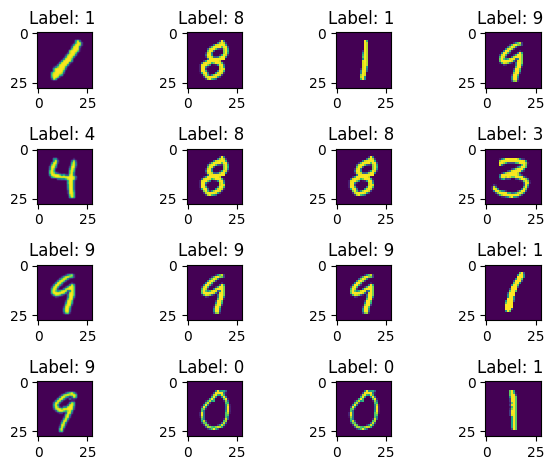

In [5]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels

# get some random training images
rnd = np.random.randint(low=0, high=16, size=16)

plt.figure()
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    plt.imshow(X_train[rnd[i-1]].reshape((28,28)))
    plt.title(f"Label: {y_train[rnd[i-1]]} ")

I have made a new list **"Normalised_data"** which contains the normalised data and its corresponding labels

In [6]:
# define your dataset for pre-processing into Neural Network

# The new data has X as standardised and the labels
Normalised_data = []
for i in range(X_train.shape[0]):
  Normalised_data.append([X_train[i], y_train[i]])


#Hyper parameters that are used in the model
n_epochs = 10
batch_size_train = 128
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.9
log_interval = 10

random_seed = 1
th.backends.cudnn.enabled = False


## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Linear```](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [```nn.ReLU```](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- [```nn.BatchNorm1d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)


In [7]:
# define a child class of nn.Module for your model
# specify the architecture here itself
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(th.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = th.nn.Linear(784, 196, bias=True)
        self.nl1 = th.nn.ReLU()
        self.fc2 = th.nn.Linear(196, 50, bias=True)
        self.bn = th.nn.BatchNorm1d(num_features=50)
        self.fc3 = th.nn.Linear(50,10 , bias=True)

    def forward(self, x):
        x = self.fc1(x)
        x = self.nl1(x)
        x = self.fc2(x)
        x = self.nl1(x)
        x = self.bn(x)
        x = self.fc3(x)
        return th.nn.functional.softmax(x, dim=-1)



## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [8]:
def train(model, optimizer, criterion, train_loader, display_step=None):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [9]:
def predict(model, test_loader):
    yhats = []
    for batch_idx, data in enumerate(test_loader):
        yhat = model(data)
        yhat = th.detach(yhat).numpy()
        for i in yhat:
            yhats.append(np.argmax(i))
    return yhats

In [10]:
def accuracy(pred, labels):
    count = 0
    Correct_preds = []
    for a in range(len(pred)):
        if pred[a] == labels[a]:
            Correct_preds.append(pred[a])
            count+=1
    return count/len(pred), Correct_preds

In [11]:
from sklearn.metrics import roc_auc_score
# The ROC-AUC value for the different classes is returned in the form of a dictionary
def roc_auc_score_multiclass(y_test, predictions, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  digits = [a for a in range(0,10)]
  h = [0]*18000

  g1 = [h.copy() for i in range(10)]

  g2 = [h.copy() for i in range(10)]
  
  roc_auc_dict = {}

  for i in range(len(y_test)):
    #marking the current class as 1 and all other classes as 0
    g1[y_test[i]][i] = 1
    g2[predictions[i]][i] = 1

  for digit in digits:
    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(g1[digit], g2[digit])
    roc_auc_dict[digit] = roc_auc
  return roc_auc_dict

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [12]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = F.nll_loss

train_loader = th.utils.data.DataLoader(Normalised_data,batch_size=batch_size_train, shuffle=True)

for i in range(n_epochs):
    train(model, optimizer, criterion, train_loader)


## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [13]:
predictions = []
reshaped = th.flatten(X_test, start_dim=1)
test_loader = th.utils.data.DataLoader(X_test,batch_size=batch_size_test)
predictions = predict(model, test_loader)

acuuracy_and_array = accuracy(predictions,y_test)
df = {'predictions': [], 'y_test': [], 'correct_pred': []}
for i in range(0,10):
    df['predictions'].append(predictions.count(i))
    df['y_test'].append(list(y_test).count(i))
    df['correct_pred'].append(acuuracy_and_array[1].count(i))

#### Calculating the AUC score for different classes and the overall accuracy of the model

In [14]:
roc_scores = roc_auc_score_multiclass(y_test, predictions)
print("The overall Acuuracy of the Model is:" , acuuracy_and_array[0])

The overall Acuuracy of the Model is: 0.9755


#### Representing the Predicted values, actual values and ROC- AUC values in the form of a data frame

In [15]:
df = pd.DataFrame(df)
df['Auc-score'] = roc_scores.values()
print(df) 

   predictions  y_test  correct_pred  Auc-score
0         1778    1776          1746   0.990568
1         2011    2008          1987   0.994021
2         1818    1800          1753   0.984938
3         1760    1800          1725   0.978086
4         1760    1767          1723   0.986410
5         1626    1628          1579   0.983515
6         1741    1731          1702   0.990425
7         1898    1896          1852   0.986968
8         1750    1721          1680   0.985938
9         1858    1873          1812   0.982290


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Other than this, save the trained model in a file named ```ass_2.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py``` class file and the ```ass_2.pt``` model-weights file to the repository.

In [16]:
# from google.colab import files
th.save(model, 'ass_2.pt')
# files.download('ass_2.pt') # download the file from the Colab session for submission

Check if it got saved right!

In [17]:
# load the model, use predict function
from model import *
loaded = th.load('ass_2.pt')
x = predict(loaded, test_loader)
print(accuracy(x, y_test)[0])


0.9755
